# Validate Artemis Partitions

Ensure that the split of the dataset in train, validation and test does
not cause a mismatch between the data in the different partitions

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter

In [2]:
artemis_file = "../artemis-ANALYSIS.csv"
dataset = pandas.read_csv(artemis_file)
dataset.sort_values('art_style')

,index,art_style,painting,emotion,utterance,repetition,split,tokens,tokens_len,utterance_spelled,tokens_encoded,emotion_label,localpath
52812,34543,Abstract_Expressionism,milton-resnick_untitled-1988,[0.2 0. 0.2 0. 0. 0. 0. 0.2 0.4],this just looks like gray smudges there is zer...,5,train,"['this', 'just', 'looks', 'like', 'gray', 'smu...",13,this just looks like gray smudges there is zer...,"[1, 20, 138, 56, 30, 881, 5952, 232, 17, 13463...",8,/Users/ricardokleinlein/Desktop/wikiart/Abstra...
68619,7056,Abstract_Expressionism,sam-francis_trietto-iii-1991,[0. 0. 0.16666667 0. 0...,the blotchy red appearance signifies blood spo...,6,train,"['the', 'blotchy', 'red', 'appearance', 'signi...",11,the blotchy red appearance signifies blood spo...,"[1, 9, 1953, 199, 366, 6753, 2148, 1239, 14, 5...",4,/Users/ricardokleinlein/Desktop/wikiart/Abstra...
68618,6312,Abstract_Expressionism,sam-francis_trietto-4-sfe-077rc-1991,[0.5 0. 0.33333333 0. 0...,though abstract the painting resembles a baby ...,6,train,"['though', 'abstract', 'the', 'painting', 'res...",19,though abstract the painting resembles a baby ...,"[1, 133, 769, 9, 112, 2426, 45, 319, 214, 423,...",0,/Users/ricardokleinlein/Desktop/wikiart/Abstra...
68617,7086,Abstract_Expressionism,sam-francis_towards-disappearance-ii-1958,[0.16666667 0. 0. 0.5 0...,the various shapes with bright colors is like ...,6,test,"['the', 'various', 'shapes', 'with', 'bright',...",11,the various shapes with bright colors is like ...,"[1, 9, 3352, 83, 38, 77, 78, 17, 30, 45, 125, ...",3,/Users/ricardokleinlein/Desktop/wikiart/Abstra...
14577,198699,Abstract_Expressionism,dan-christensen_bajo-sexto-1984,[0. 0. 0.4 0.2 0.2 0.2 0. 0. 0. ],i like the suppleness but am in awe of the col...,5,train,"['i', 'like', 'the', 'suppleness', 'but', 'am'...",12,i like the suppleness but am in awe of the col...,"[1, 35, 30, 9, 7061, 161, 36, 8, 2464, 89, 9, ...",2,/Users/ricardokleinlein/Desktop/wikiart/Abstra...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43667,25252,Ukiyo_e,kitagawa-utamaro_not_detected_233134,[0.2 0. 0.2 0.4 0. 0. 0. 0.2 0. ],the expression makes the woman looked distress...,5,test,"['the', 'expression', 'makes', 'the', 'woman',...",7,the expression makes the woman looked distressed,"[1, 9, 209, 27, 9, 21, 2660, 8809, 2, 0, 0, 0,...",3,/Users/ricardokleinlein/Desktop/wikiart/Ukiyo_...
43666,25534,Ukiyo_e,kitagawa-utamaro_not_detected_233133,[0.4 0. 0.2 0. 0.2 0. 0. 0.2 0. ],this puts me in awe a little because i can not...,5,train,"['this', 'puts', 'me', 'in', 'awe', 'a', 'litt...",35,this puts me in awe a little because i can not...,"[1, 20, 370, 53, 8, 2464, 45, 420, 364, 35, 14...",0,/Users/ricardokleinlein/Desktop/wikiart/Ukiyo_...
43665,25967,Ukiyo_e,kitagawa-utamaro_not_detected_233132,[0.2 0. 0. 0.2 0. 0.2 0. 0.2 0.2],the woman appears to enjoy looking down at her...,5,train,"['the', 'woman', 'appears', 'to', 'enjoy', 'lo...",11,the woman appears to enjoy looking down at her...,"[1, 9, 21, 252, 14, 141, 33, 298, 34, 28, 5056...",0,/Users/ricardokleinlein/Desktop/wikiart/Ukiyo_...
43663,25972,Ukiyo_e,kitagawa-utamaro_not_detected_233129,[0.16666667 0. 0.16666667 0.33333333 0...,the two women seem like they are having a plea...,6,test,"['the', 'two', 'women', 'seem', 'like', 'they'...",11,the two women seem like they are having a plea...,"[1, 9, 236, 402, 165, 30, 239, 116, 1081, 45, ...",3,/Users/ricardokleinlein/Desktop/wikiart/Ukiyo_...


In [3]:
train_data = dataset[dataset['split'] == "train"]
val_data = dataset[dataset['split'] == "val"]
test_data = dataset[dataset['split'] == "test"]
fmt = f"Train samples (#) = {len(train_data)}\n" \
      f"Val samples (#) = {len(val_data)}\n" \
      f"Test samples (#) = {len(test_data)}"
print(fmt)

Train samples (#) = 48019
Val samples (#) = 12004
Test samples (#) = 20008


## How many samples have +1 best emotion?

In [4]:
def tonumpy(str_dists: pandas.Series) -> numpy.ndarray:
    """

    """
    return numpy.array([
        numpy.fromstring(s[1:-1], dtype=float, sep=' ') for s in str_dists])

ground_truth = tonumpy(test_data['emotion'])
count = 0
for i, x in enumerate(tqdm(ground_truth)):
    argmaxs = numpy.flatnonzero(x == numpy.max(x))
    if len(argmaxs) > 1:
        count += 1
print(f"Found {count} samples without a single emotion label in test set")


100%|██████████| 20008/20008 [00:01<00:00, 10853.56it/s]

Found 5063 samples without a single emotion label in test set


## By most probable emotion

In [60]:
emotions = ["amusement", "anger", "awe", "contentment", "disgust",
          "excitement", "fear", "sadness", "something else"]
idx2em = lambda x: emotions[x]
top_emotion_train = numpy.argmax(tonumpy(train_data['emotion']), axis=1)
top_emotion_train = list(map(idx2em, top_emotion_train))
top_emotion_val = numpy.argmax(tonumpy(val_data['emotion']), axis=1)
top_emotion_val = list(map(idx2em, top_emotion_val))
top_emotion_test = numpy.argmax(tonumpy(test_data['emotion']), axis=1)
top_emotion_test = list(map(idx2em, top_emotion_test))

top_emotion_train = Counter(top_emotion_train).most_common()
top_emotion_train = [(x[0], x[1] / len(train_data)) for x in top_emotion_train]
print(f"Train distribution of emotions: {top_emotion_train}")
top_emotion_val = Counter(top_emotion_val).most_common()
top_emotion_val = [(x[0], x[1] / len(val_data)) for x in top_emotion_val]
print(f"\nVal distribution of emotions: {top_emotion_val}")
top_emotion_test = Counter(top_emotion_test).most_common()
top_emotion_test = [(x[0], x[1] / len(test_data)) for x in top_emotion_test]
print(f"\nTest distribution of emotions: {top_emotion_test}")

Train distribution of emotions: [('contentment', 0.3502780149524147), ('awe', 0.19209063079197816), ('amusement', 0.14385972219329848), ('sadness', 0.08409171369666174), ('fear', 0.08130115162748079), ('something else', 0.06364147524938045), ('excitement', 0.04425331639559341), ('disgust', 0.029321726816468482), ('anger', 0.011162248276723796)]

Val distribution of emotions: [('contentment', 0.35029990003332223), ('awe', 0.19210263245584805), ('amusement', 0.14386871042985672), ('sadness', 0.08405531489503498), ('fear', 0.08130623125624792), ('something else', 0.06364545151616129), ('excitement', 0.044235254915028326), ('disgust', 0.029323558813728758), ('anger', 0.011162945684771743)]

Test distribution of emotions: [('contentment', 0.35025989604158336), ('awe', 0.19207317073170732), ('amusement', 0.1438424630147941), ('sadness', 0.08406637345061975), ('fear', 0.08131747301079569), ('something else', 0.06362455017992803), ('excitement', 0.04428228708516593), ('disgust', 0.029338264694

## By painting style

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

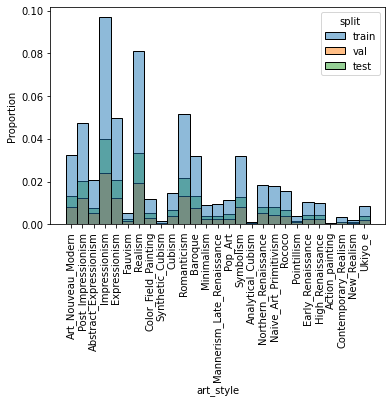

In [7]:
sns.histplot(data=dataset, x='art_style', hue="split", stat="proportion")
plt.xticks(rotation=90)